# Global imports

In [161]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from qksvm.QKSVC import QKSVC

# Customized score functions
from qksvm.scores import get_scores, print_scores, print_cv_scores

# Custom visualization tools
from qksvm.visualization_tools import plot_dataset, plot_predictions, plot_decisions

seed = 12345

# Blobs dataset

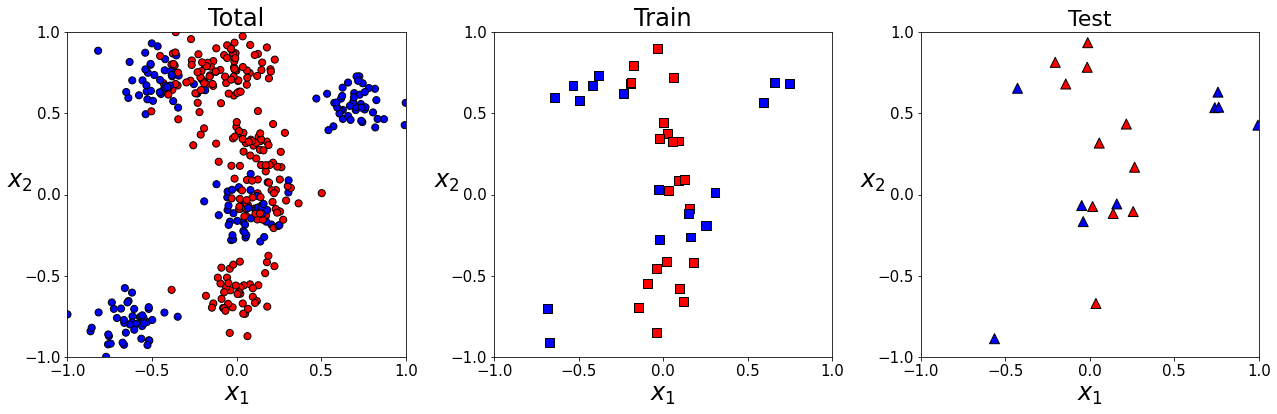

In [180]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

n_samples = 400
X, y = make_blobs(n_samples=n_samples, n_features=2, centers=9, random_state=120, shuffle=True, cluster_std=1.2)
y[y%2 == 0] = -1
y[y > 0] = 1

xmin = -1; xmax = 1
X = MinMaxScaler(feature_range=(xmin, xmax)).fit_transform(X)
axes = [xmin, xmax, xmin, xmax]

train_size = 40
test_size = 20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    train_size=train_size, test_size=test_size,
    stratify=y, random_state=101
)

# Visualize the dataset
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
axes = [xmin, xmax, xmin, xmax]

ax1.set_title("Total", fontsize=24)
plot_dataset(X, y, ax1, axes)

ax2.set_title("Train", fontsize=24)
plot_dataset(X_train, y_train, ax2, axes, marker='s', size=80)

ax3.set_title("Test", fontsize=22)
plot_dataset(X_test, y_test, ax3, axes, marker='^', size=100)

plt.rcParams['font.size'] = 15
plt.tight_layout()
plt.show()

# RBF SVM

Best grid search parameters: {'C': 100, 'gamma': 1.6}
Best training score: 0.898989898989899

Train scores:
   Balanced accuracy:  0.95
                  F1:  0.95
             ROC_AUC:  0.99
                 MCC:  0.90

Test scores:
   Balanced accuracy:  0.81
                  F1:  0.80
             ROC_AUC:  0.94
                 MCC:  0.62


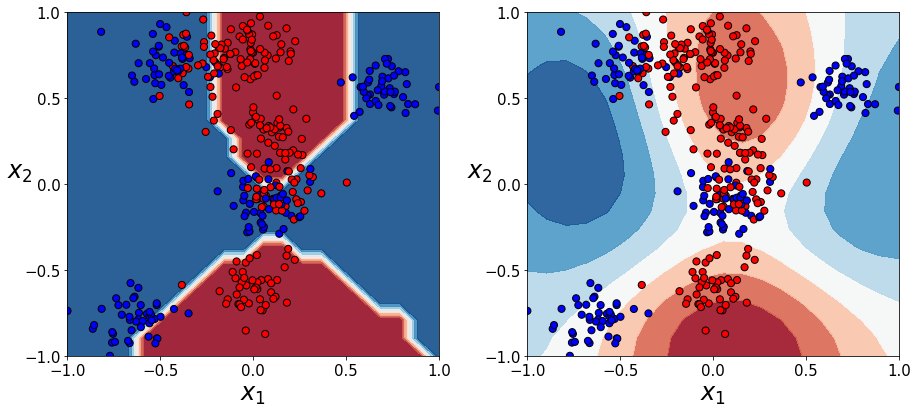

In [32]:
param_grid = {
    "gamma": [0.001, 0.005, 0.01, 0.1, 0.5, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 5.0, 10.0],
    "C": [1, 2, 4, 6, 8, 10, 100, 1000],
}

clf = GridSearchCV(
    estimator=SVC(kernel='rbf'),
    param_grid=param_grid,
    scoring='balanced_accuracy',
    n_jobs=1,
    refit=True,
    cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=seed),
)
clf.fit(X_train, y_train)

print('Best grid search parameters:', clf.best_params_)
print('Best training score:', clf.best_score_)

train_scores = get_scores(clf.best_estimator_, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(clf.best_estimator_, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
plot_predictions(clf.best_estimator_, ax1, axes, N=20)
plot_dataset(X, y, ax1, axes)
plot_decisions(clf.best_estimator_, ax2, axes, N=20)
plot_dataset(X, y, ax2, axes)
plt.tight_layout()
plt.show()

## Model cross-validation

In [125]:
np.random.seed(seed)

scoring = 0 # 0=acc, 1=f1, 2=roc
best_score = 0.0
scores_tr = []
scores_tt = []

param_grid = {
    "gamma": [0.001, 0.005, 0.01, 0.1, 0.5, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 5.0, 10.0],
    "C": [1, 2, 4, 6, 8, 10, 100, 200, 400],
}

train_size = 200
test_size = 20
n_splits = 5

for _seed in np.random.randint(2**16-1, size=5):
    # print('rnd seed', _seed)

    cv = StratifiedShuffleSplit(
        n_splits=n_splits, 
        train_size=train_size, test_size=test_size, 
        random_state=_seed
    )

    i = 0
    for train, test in cv.split(X, y):
        i += 1
        # print(f"Train/Test CV Subset {i}")

        clf = GridSearchCV(
            estimator=SVC(kernel='rbf'),
            param_grid=param_grid,
            scoring='matthews_corrcoef',
            n_jobs=1,
            refit=True,
            cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=_seed),
        )

        clf.fit(X[train,:], y[train])

        train_scores = get_scores(clf.best_estimator_, X[train,:], y[train])
        test_scores = get_scores(clf.best_estimator_, X[test,:], y[test])
        scores_tr.append(train_scores)
        scores_tt.append(test_scores)
        if test_scores[scoring] > best_score:
            best_score = test_scores[scoring]
            best_clf = clf.best_estimator_

print('')
print('==== Cross-Validation Scores ====')
print("\nBest train score: ", best_score)
print_cv_scores(scores_tr, title='Train set:')
print_cv_scores(scores_tt, title='Test set:')


==== Cross-Validation Scores ====

Best train score:  0.9444444444444444

Train set:
   Balanced accuracy:  0.88 +- 0.03
                  F1:  0.88 +- 0.03
             ROC_AUC:  0.95 +- 0.02
                 MCC:  0.77 +- 0.06

Test set:
   Balanced accuracy:  0.83 +- 0.07
                  F1:  0.84 +- 0.07
             ROC_AUC:  0.94 +- 0.04
                 MCC:  0.69 +- 0.15


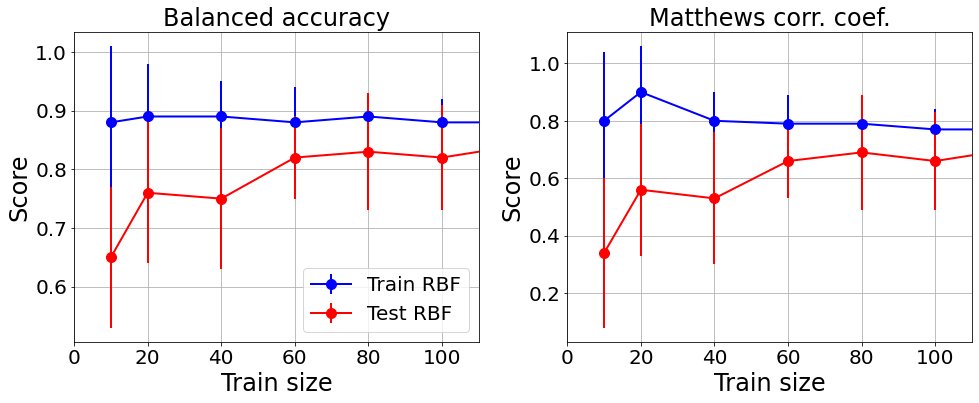

In [155]:
import pandas as pd
from io import StringIO

TESTDATA = StringIO("""
size acc_tr_mean acc_tr_std  mcc_tr_mean mcc_tr_std  acc_te_mean acc_te_std  mcc_te_mean mcc_te_std
10   0.88 0.13   0.80 0.24   0.65 0.12   0.34 0.26
20   0.89 0.09   0.90 0.16   0.76 0.12   0.56 0.23
40   0.89 0.06   0.80 0.10   0.75 0.12   0.53 0.23 
60   0.88 0.06   0.79 0.10   0.82 0.07   0.66 0.13
80   0.89 0.04   0.79 0.08   0.83 0.10   0.69 0.20
100  0.88 0.04   0.77 0.07   0.82 0.09   0.66 0.17 
120  0.88 0.04   0.77 0.07   0.84 0.07   0.70 0.14
140  0.89 0.03   0.78 0.06   0.81 0.08   0.66 0.15
160  0.89 0.03   0.79 0.04   0.85 0.06   0.72 0.12
200  0.88 0.03   0.77 0.06   0.83 0.07   0.69 0.15
""")

df_rbf = pd.read_table(TESTDATA, sep="\s+")

# Visualization
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# acc
df_rbf.plot(ax=ax[0], x='size', y='acc_tr_mean', yerr='acc_tr_std', c='blue', lw=2, ls='-', marker='o', markersize=10, label='Train RBF')
df_rbf.plot(ax=ax[0], x='size', y='acc_te_mean', yerr='acc_te_std', c='red', lw=2, ls='-', marker='o', markersize=10, label='Test RBF')
# mcc
df_rbf.plot(ax=ax[1], x='size', y='mcc_tr_mean', yerr='mcc_tr_std', c='blue', lw=2, ls='-', marker='o', markersize=10, label='Train RBF', legend=False)
df_rbf.plot(ax=ax[1], x='size', y='mcc_te_mean', yerr='mcc_te_std', c='red', lw=2, ls='-', marker='o', markersize=10, label='Test RBF', legend=False)

ax[0].set_title('Balanced accuracy')
ax[1].set_title('Matthews corr. coef.')
for i in range(len(ax)):
    ax[i].set_xlabel('Train size', fontsize=24)
    ax[i].set_ylabel('Score', fontsize=24)
    ax[i].set_xlim(0, 110)
    ax[i].grid()
ax[0].legend(loc='lower right')
plt.tight_layout()
plt.show()

# QKSVC

In [59]:
def model(params):

    qsvc = QKSVC(
        n_qubits=params['n_qubits'],
        n_layers=params['n_layers'],
        feature_map=params['feature_map'], entanglement='linear',
        alpha=params['alpha'], C=params['C'], 
        random_state=seed
    )
    qsvc.fit(X_train, y_train)

    train_scores = get_scores(qsvc, X_train, y_train)
    print_scores(train_scores, title='Train scores:')

    test_scores  = get_scores(qsvc, X_test,  y_test)
    print_scores(test_scores, title='Test scores:')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
    plot_predictions(qsvc, ax1, axes, N=20)
    plot_dataset(X, y, ax1, axes)
    plot_decisions(qsvc, ax2, axes, N=20)
    plot_dataset(X, y, ax2, axes)
    plt.tight_layout()
    plt.show()


Train scores:
   Balanced accuracy:  0.88
                  F1:  0.88
             ROC_AUC:  0.97
                 MCC:  0.75

Test scores:
   Balanced accuracy:  0.82
                  F1:  0.80
             ROC_AUC:  0.90
                 MCC:  0.66


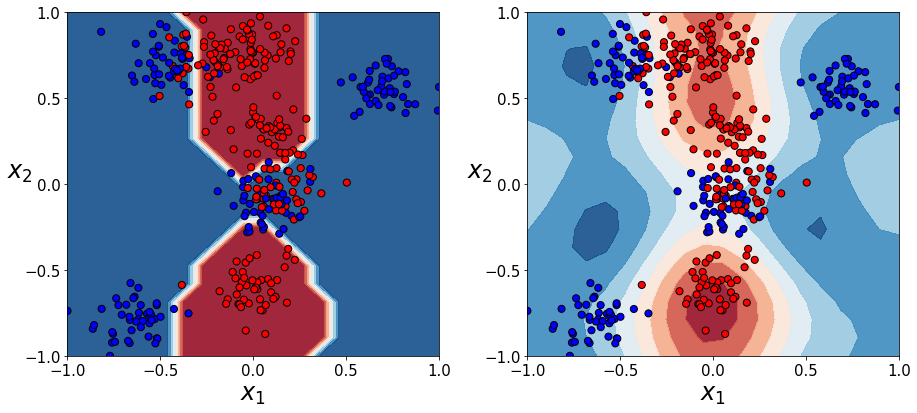

In [173]:
model({'n_qubits': 2, 'n_layers': 2, 'feature_map': ['h', 'rz'], 'alpha': 3.1, 'C': 1.0})

In [174]:
np.random.seed(seed)

scoring = 0 # 0=acc, 1=f1, 2=roc
best_score = 0.0
scores_tr = []
scores_tt = []

train_size = 40
test_size = 20
n_splits = 5

for _seed in np.random.randint(2**16-1, size=5):
    # print('rnd seed', _seed)

    cv = StratifiedShuffleSplit(
        n_splits=n_splits, 
        train_size=train_size, test_size=test_size, 
        random_state=_seed
    )

    i = 0
    for train, test in cv.split(X, y):
        i += 1
        # print(f"Train/Test CV Subset {i}")

        qsvc = QKSVC(
            n_qubits=2, n_layers=2, feature_map=['h', 'rz'], entanglement='linear', 
            alpha=3.1, C=1,
            random_state=_seed
        )
        qsvc.fit(X[train,:], y[train])

        train_scores = get_scores(qsvc, X[train,:], y[train])
        test_scores = get_scores(qsvc, X[test,:], y[test])
        scores_tr.append(train_scores)
        scores_tt.append(test_scores)
        if test_scores[scoring] > best_score:
            best_score = test_scores[scoring]
            best_qsvc = qsvc

print('')
print('==== Cross-Validation Scores ====')
print("\nBest train score: ", best_score)
print_cv_scores(scores_tr, title='Train set:')
print_cv_scores(scores_tt, title='Test set:')


==== Cross-Validation Scores ====

Best train score:  1.0

Train set:
   Balanced accuracy:  0.85 +- 0.05
                  F1:  0.86 +- 0.05
             ROC_AUC:  0.94 +- 0.02
                 MCC:  0.73 +- 0.09

Test set:
   Balanced accuracy:  0.81 +- 0.09
                  F1:  0.81 +- 0.09
             ROC_AUC:  0.89 +- 0.09
                 MCC:  0.65 +- 0.17


## Hyperparameter search

Best grid search parameters: {'C': 10, 'alpha': 2.5, 'feature_map': ['rx', 'cy'], 'n_layers': 3, 'n_qubits': 3}
Best training score: 0.8540819657211

Train scores:
   Balanced accuracy:  0.93
                  F1:  0.93
             ROC_AUC:  0.99
                 MCC:  0.85

Test scores:
   Balanced accuracy:  0.86
                  F1:  0.85
             ROC_AUC:  0.97
                 MCC:  0.74


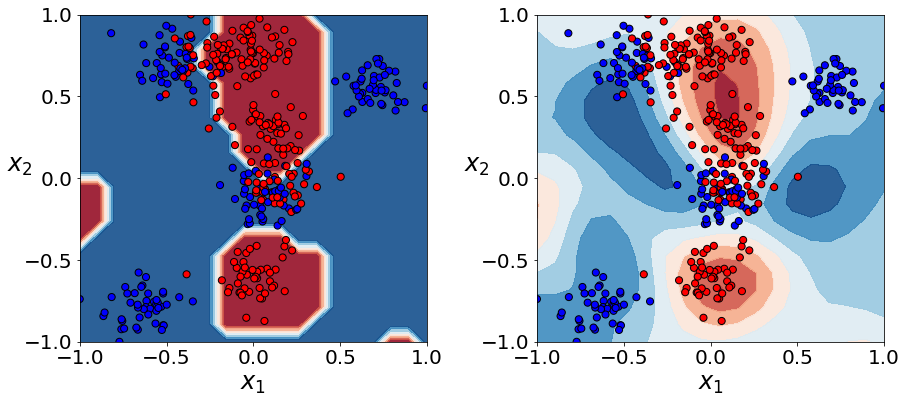

In [113]:
np.random.seed(seed=seed)

param_grid = {
    "alpha": [0.5, 1.0, 1.5, 2.0, 2.5, 3.0],
    "C": [1, 10],
    "n_layers": [2, 3, 4, 5],
    "n_qubits": [2, 3, 4, 5],
    "feature_map": [
                    ['rx', 'cy'], 
                    ['ry', 'cx'], 
                    ['rx', 'cry'], 
                    ['ry', 'crx'], 
                    ['rx', 'ryy'], 
                    ['ry', 'rxx'], 
                   ],
}

qsvc = GridSearchCV(
    estimator=QKSVC(entanglement='linear', random_state=seed),
    param_grid=param_grid,
    scoring='matthews_corrcoef',
    n_jobs=4,
    refit=True,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=seed),
)
qsvc.fit(X_train, y_train)

print('Best grid search parameters:', qsvc.best_params_)
print('Best training score:', qsvc.best_score_)

train_scores = get_scores(qsvc.best_estimator_, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc.best_estimator_, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
plot_predictions(qsvc, ax1, axes, N=20)
plot_dataset(X, y, ax1, axes)
plot_decisions(qsvc, ax2, axes, N=20)
plot_dataset(X, y, ax2, axes)
plt.tight_layout()
plt.show()

965
1057
0.8540819657211
params {'C': 10, 'alpha': 3.0, 'feature_map': ['rx', 'cy'], 'n_layers': 2, 'n_qubits': 3}

Train scores:
   Balanced accuracy:  0.95
                  F1:  0.95
             ROC_AUC:  0.99
                 MCC:  0.90

Test scores:
   Balanced accuracy:  0.86
                  F1:  0.85
             ROC_AUC:  0.86
                 MCC:  0.74


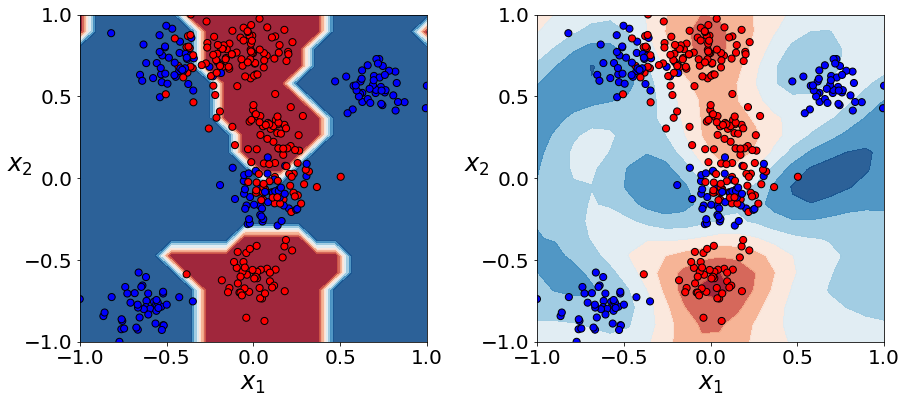

In [114]:
print(qsvc.best_index_)

i = -2
idx = np.argsort(qsvc.cv_results_['mean_test_score'])
print(idx[i])
print(qsvc.cv_results_['mean_test_score'][idx[i]])
print('params', qsvc.cv_results_['params'][idx[i]])

model(qsvc.cv_results_['params'][idx[i]])

## Model cross-validation

In [186]:
np.random.seed(seed)

scoring = 0 # 0=acc, 1=f1, 2=roc
best_score = 0.0
scores_tr = []
scores_tt = []

train_size = 40
test_size = 20
n_splits = 5

for _seed in np.random.randint(2**16-1, size=5):
    # print('rnd seed', _seed)

    cv = StratifiedShuffleSplit(
        n_splits=n_splits, 
        train_size=train_size, test_size=test_size, 
        random_state=_seed
    )

    i = 0
    for train, test in cv.split(X, y):
        i += 1
        # print(f"Train/Test CV Subset {i}")

        # {'C': 10, 'alpha': 2.5, 'feature_map': ['rx', 'cy'], 'n_layers': 3, 'n_qubits': 3}
        qsvc = QKSVC(
            n_qubits=3, n_layers=3, feature_map=['rx', 'cy'], entanglement='linear', 
            alpha=2.5, C=10,
            random_state=_seed
        )
        qsvc.fit(X[train,:], y[train])

        train_scores = get_scores(qsvc, X[train,:], y[train])
        test_scores = get_scores(qsvc, X[test,:], y[test])
        scores_tr.append(train_scores)
        scores_tt.append(test_scores)
        if test_scores[scoring] > best_score:
            best_score = test_scores[scoring]
            best_qsvc = qsvc

print('')
print('==== Cross-Validation Scores ====')
print("\nBest train score: ", best_score)
print_cv_scores(scores_tr, title='Train set:')
print_cv_scores(scores_tt, title='Test set:')


==== Cross-Validation Scores ====

Best train score:  0.9444444444444444

Train set:
   Balanced accuracy:  0.92 +- 0.03
                  F1:  0.92 +- 0.03
             ROC_AUC:  0.97 +- 0.02
                 MCC:  0.85 +- 0.06

Test set:
   Balanced accuracy:  0.82 +- 0.08
                  F1:  0.82 +- 0.08
             ROC_AUC:  0.90 +- 0.07
                 MCC:  0.65 +- 0.16


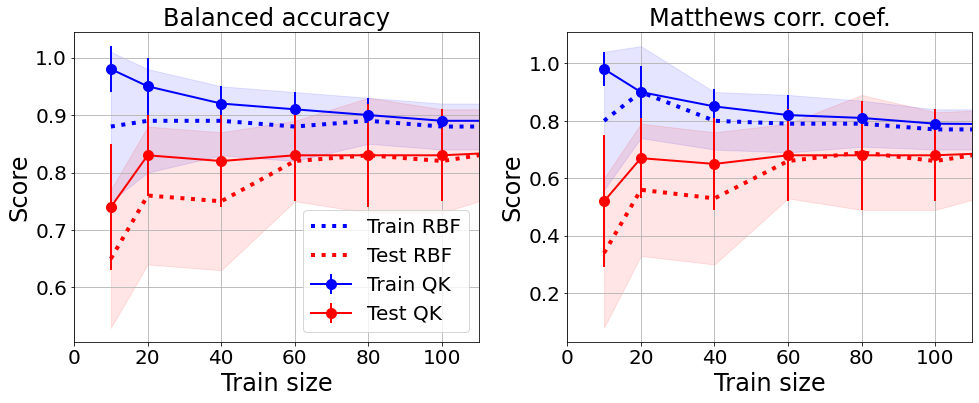

In [157]:
import pandas as pd
from io import StringIO

TESTDATA = StringIO("""
size acc_tr_mean acc_tr_std  mcc_tr_mean mcc_tr_std  acc_te_mean acc_te_std  mcc_te_mean mcc_te_std
10   0.98 0.04  0.98 0.06  0.74 0.11  0.52 0.23 
20   0.95 0.05  0.90 0.09  0.83 0.07  0.67 0.14 
40   0.92 0.03  0.85 0.06  0.82 0.08  0.65 0.16 
60   0.91 0.03  0.82 0.07  0.83 0.08  0.68 0.16
80   0.90 0.03  0.81 0.06  0.83 0.09  0.68 0.19 
100  0.89 0.02  0.79 0.05  0.83 0.08  0.68 0.16
200  0.89 0.02  0.78 0.03  0.86 0.07  0.73 0.14
""")

df = pd.read_table(TESTDATA, sep="\s+")

# Visualization
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1, 2, figsize=(14,6))

# acc
df.plot(ax=ax[0], x='size', y='acc_tr_mean', yerr='acc_tr_std', c='blue', lw=2, ls='-', marker='o', markersize=10, label='Train QK')
df.plot(ax=ax[0], x='size', y='acc_te_mean', yerr='acc_te_std', c='red', lw=2, ls='-', marker='o', markersize=10, label='Test QK')

df_rbf.plot(ax=ax[0], x='size', y='acc_tr_mean', yerr=None, c='blue', lw=4, ls=':', marker=None, markersize=10, label='Train RBF', legend=False)
ax[0].fill_between(df_rbf['size'], df_rbf['acc_tr_mean']-df_rbf['acc_tr_std'], df_rbf['acc_tr_mean']+df_rbf['acc_tr_std'], alpha=0.1, color='blue')

df_rbf.plot(ax=ax[0], x='size', y='acc_te_mean', yerr=None, c='red', lw=4, ls=':', marker=None, markersize=10, label='Test RBF', legend=False)
ax[0].fill_between(df_rbf['size'], df_rbf['acc_te_mean']-df_rbf['acc_te_std'], df_rbf['acc_te_mean']+df_rbf['acc_te_std'], alpha=0.1, color='red')

# mcc
df.plot(ax=ax[1], x='size', y='mcc_tr_mean', yerr='mcc_tr_std', c='blue', lw=2, ls='-', marker='o', markersize=10, label='Train QK', legend=False)
df.plot(ax=ax[1], x='size', y='mcc_te_mean', yerr='mcc_te_std', c='red', lw=2, ls='-', marker='o', markersize=10, label='Test QK', legend=False)

df_rbf.plot(ax=ax[1], x='size', y='mcc_tr_mean', yerr=None, c='blue', lw=4, ls=':', marker=None, markersize=10, label='Train RBF', legend=False)
ax[1].fill_between(df_rbf['size'], df_rbf['mcc_tr_mean']-df_rbf['mcc_tr_std'], df_rbf['mcc_tr_mean']+df_rbf['mcc_tr_std'], alpha=0.1, color='blue')

df_rbf.plot(ax=ax[1], x='size', y='mcc_te_mean', yerr=None, c='red', lw=4, ls=':', marker=None, markersize=10, label='Test RBF', legend=False)
ax[1].fill_between(df_rbf['size'], df_rbf['mcc_te_mean']-df_rbf['mcc_te_std'], df_rbf['mcc_te_mean']+df_rbf['mcc_te_std'], alpha=0.1, color='red')

ax[0].set_title('Balanced accuracy')
ax[1].set_title('Matthews corr. coef.')
for i in range(len(ax)):
    ax[i].set_xlabel('Train size', fontsize=24)
    ax[i].set_ylabel('Score', fontsize=24)
    ax[i].set_xlim(0, 110)
    ax[i].grid()
ax[0].legend(loc='lower right')
plt.tight_layout()
plt.show()

# Test 1

Best grid search parameters: {'C': 10, 'alpha': 0.75, 'feature_map': ['rx', 'cy'], 'n_layers': 4, 'n_qubits': 10}
Best training score: 0.859116756396542

Train scores:
   Balanced accuracy:  0.92
                  F1:  0.92
             ROC_AUC:  0.98
                 MCC:  0.85

Test scores:
   Balanced accuracy:  0.86
                  F1:  0.85
             ROC_AUC:  0.91
                 MCC:  0.74


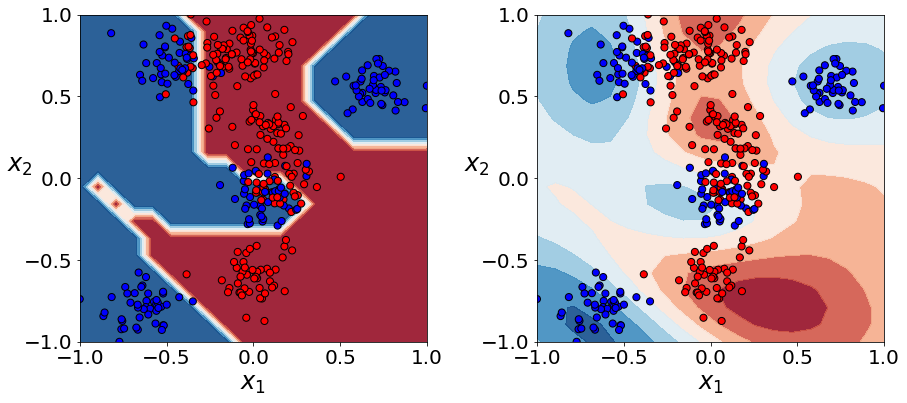

In [146]:
np.random.seed(seed=seed)

param_grid = {
    "alpha": [0.1, 0.25, 0.5, 0.75, 1.0, 2.0],
    "C": [1, 10, 100],
    "n_layers": [2, 4, 6, 8, 10, 12, 14, 16],
    "n_qubits": [2, 3, 4, 5, 6, 8, 10, 12],
    "feature_map": [
                    ['rx', 'cy'], 
                   ],
}

gs = GridSearchCV(
    estimator=QKSVC(entanglement='linear', random_state=seed),
    param_grid=param_grid,
    scoring='matthews_corrcoef',
    n_jobs=1,
    refit=True,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=seed),
)
gs.fit(X_train, y_train)

print('Best grid search parameters:', gs.best_params_)
print('Best training score:', gs.best_score_)

train_scores = get_scores(gs.best_estimator_, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(gs.best_estimator_, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
plot_predictions(qsvc, ax1, axes, N=20)
plot_dataset(X, y, ax1, axes)
plot_decisions(qsvc, ax2, axes, N=20)
plot_dataset(X, y, ax2, axes)
plt.tight_layout()
plt.show()

590
535
0.8194444444444443
params {'C': 10, 'alpha': 0.5, 'feature_map': ['rx', 'cy'], 'n_layers': 6, 'n_qubits': 12}

Train scores:
   Balanced accuracy:  0.92
                  F1:  0.92
             ROC_AUC:  0.98
                 MCC:  0.85

Test scores:
   Balanced accuracy:  0.86
                  F1:  0.85
             ROC_AUC:  0.91
                 MCC:  0.74


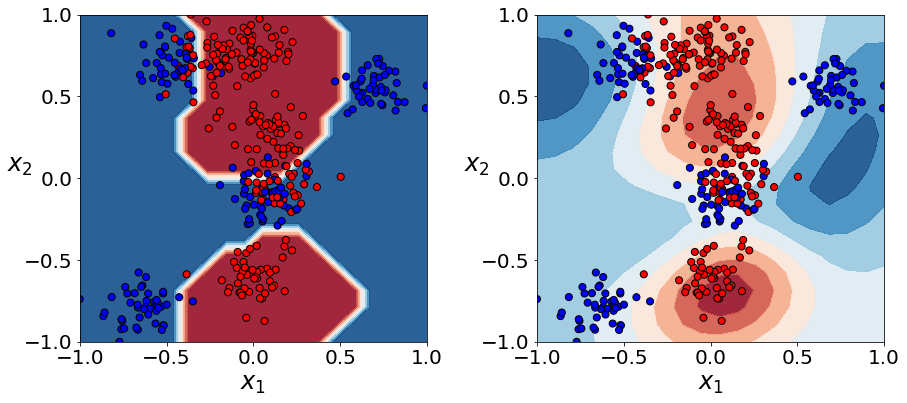

In [148]:
print(gs.best_index_)

i = -2
idx = np.argsort(gs.cv_results_['mean_test_score'])
print(idx[i])
print(gs.cv_results_['mean_test_score'][idx[i]])
print('params', gs.cv_results_['params'][idx[i]])

model(gs.cv_results_['params'][idx[i]])

## Model cross-validation

In [151]:
np.random.seed(seed)

scoring = 0 # 0=acc, 1=f1, 2=roc
best_score = 0.0
scores_tr = []
scores_tt = []

# train_size = 10
# test_size = 10
n_splits = 5

for _seed in np.random.randint(2**16-1, size=5):
    # print('rnd seed', _seed)

    cv = StratifiedShuffleSplit(
        n_splits=n_splits, 
        train_size=train_size, test_size=test_size, 
        random_state=_seed
    )

    i = 0
    for train, test in cv.split(X, y):
        i += 1
        # print(f"Train/Test CV Subset {i}")

        # {'C': 10, 'alpha': 0.75, 'feature_map': ['rx', 'cy'], 'n_layers': 4, 'n_qubits': 10}
        qsvc = QKSVC(
            n_qubits=10, n_layers=4, feature_map=['rx', 'cy'], entanglement='linear', 
            alpha=0.75, C=10,
            random_state=_seed
        )
        qsvc.fit(X[train,:], y[train])

        train_scores = get_scores(qsvc, X[train,:], y[train])
        test_scores = get_scores(qsvc, X[test,:], y[test])
        scores_tr.append(train_scores)
        scores_tt.append(test_scores)
        if test_scores[scoring] > best_score:
            best_score = test_scores[scoring]
            best_qsvc = qsvc

print('')
print('==== Cross-Validation Scores ====')
print("\nBest train score: ", best_score)
print_cv_scores(scores_tr, title='Train set:')
print_cv_scores(scores_tt, title='Test set:')

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
# plot_predictions(best_qsvc, ax1, axes, N=20)
# plot_dataset(X, y, ax1, axes)
# plot_decisions(best_qsvc, ax2, axes, N=20)
# plot_dataset(X, y, ax2, axes)
# plt.tight_layout()
# plt.show()


==== Cross-Validation Scores ====

Best train score:  1.0

Train set:
   Balanced accuracy:  0.89 +- 0.02
                  F1:  0.89 +- 0.02
             ROC_AUC:  0.96 +- 0.01
                 MCC:  0.77 +- 0.03

Test set:
   Balanced accuracy:  0.85 +- 0.08
                  F1:  0.85 +- 0.08
             ROC_AUC:  0.95 +- 0.05
                 MCC:  0.72 +- 0.16


# Test 2

Best grid search parameters: {'C': 1, 'alpha': 3.0, 'feature_map': ['rx', 'cx'], 'n_layers': 2, 'n_qubits': 4}
Best training score: 0.859116756396542

Train scores:
   Balanced accuracy:  0.92
                  F1:  0.92
             ROC_AUC:  0.99
                 MCC:  0.85

Test scores:
   Balanced accuracy:  0.86
                  F1:  0.85
             ROC_AUC:  0.90
                 MCC:  0.74


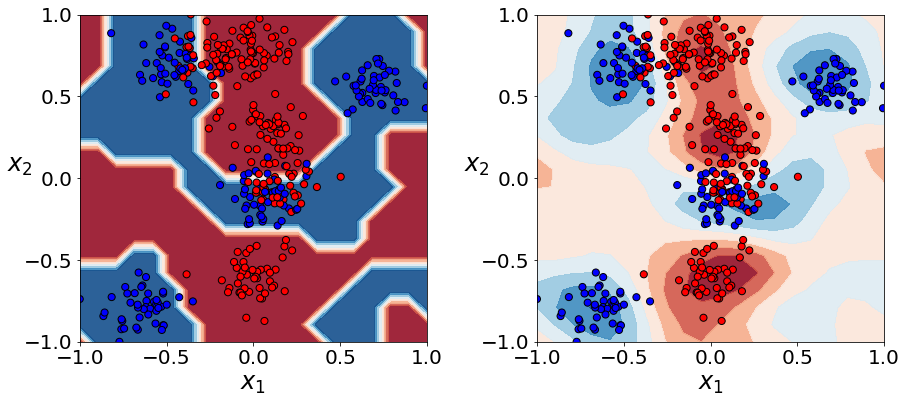

In [156]:
np.random.seed(seed=seed)

param_grid = {
    "alpha": [0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 2.5, 3.0],
    "C": [1, 10],
    "n_layers": [2, 3, 4, 5, 6, 8, 10],
    "n_qubits": [2, 3, 4, 5],
    "feature_map": [
                    ['rx', 'cx'], 
                    ['rx', 'cy'], 
                    ['rx', 'cz'], 
                    ['rx', 'ch'], 
                    ['rx', 'dcx'], 
                    ['rx', 'csx'], 
                    ['rx', 'swap'], 
                    ['rx', 'iswap'],
                    ['rx', 'rxx'],
                    ['rx', 'ryy'],
                    ['rx', 'rzz'],
                    ['rx', 'rzx'],
                   ],
}

qsvc = GridSearchCV(
    estimator=QKSVC(entanglement='linear', random_state=seed),
    param_grid=param_grid,
    scoring='matthews_corrcoef',
    n_jobs=1,
    refit=True,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=seed),
)
qsvc.fit(X_train, y_train)

print('Best grid search parameters:', qsvc.best_params_)
print('Best training score:', qsvc.best_score_)

train_scores = get_scores(qsvc.best_estimator_, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc.best_estimator_, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
plot_predictions(qsvc, ax1, axes, N=20)
plot_dataset(X, y, ax1, axes)
plot_decisions(qsvc, ax2, axes, N=20)
plot_dataset(X, y, ax2, axes)
plt.tight_layout()
plt.show()

## Model cross-validation

In [158]:
np.random.seed(seed)

scoring = 0 # 0=acc, 1=f1, 2=roc
best_score = 0.0
scores_tr = []
scores_tt = []

# train_size = 10
# test_size = 10
n_splits = 5

for _seed in np.random.randint(2**16-1, size=5):
    # print('rnd seed', _seed)

    cv = StratifiedShuffleSplit(
        n_splits=n_splits, 
        train_size=train_size, test_size=test_size, 
        random_state=_seed
    )

    i = 0
    for train, test in cv.split(X, y):
        i += 1
        # print(f"Train/Test CV Subset {i}")

        # {'C': 10, 'alpha': 0.75, 'feature_map': ['rx', 'cy'], 'n_layers': 4, 'n_qubits': 10}
        params = {'C': 1, 'alpha': 3.0, 'feature_map': ['rx', 'cx'], 'n_layers': 2, 'n_qubits': 4}
        qsvc = QKSVC(
            n_qubits=params['n_qubits'],
            n_layers=params['n_layers'],
            feature_map=params['feature_map'], entanglement='linear',
            alpha=params['alpha'], C=params['C'], 
            random_state=seed
        ) 
        qsvc.fit(X[train,:], y[train])

        train_scores = get_scores(qsvc, X[train,:], y[train])
        test_scores = get_scores(qsvc, X[test,:], y[test])
        scores_tr.append(train_scores)
        scores_tt.append(test_scores)
        if test_scores[scoring] > best_score:
            best_score = test_scores[scoring]
            best_qsvc = qsvc

print('')
print('==== Cross-Validation Scores ====')
print("\nBest train score: ", best_score)
print_cv_scores(scores_tr, title='Train set:')
print_cv_scores(scores_tt, title='Test set:')


==== Cross-Validation Scores ====

Best train score:  0.9545454545454546

Train set:
   Balanced accuracy:  0.89 +- 0.02
                  F1:  0.89 +- 0.02
             ROC_AUC:  0.96 +- 0.01
                 MCC:  0.77 +- 0.04

Test set:
   Balanced accuracy:  0.87 +- 0.06
                  F1:  0.87 +- 0.06
             ROC_AUC:  0.95 +- 0.04
                 MCC:  0.76 +- 0.13


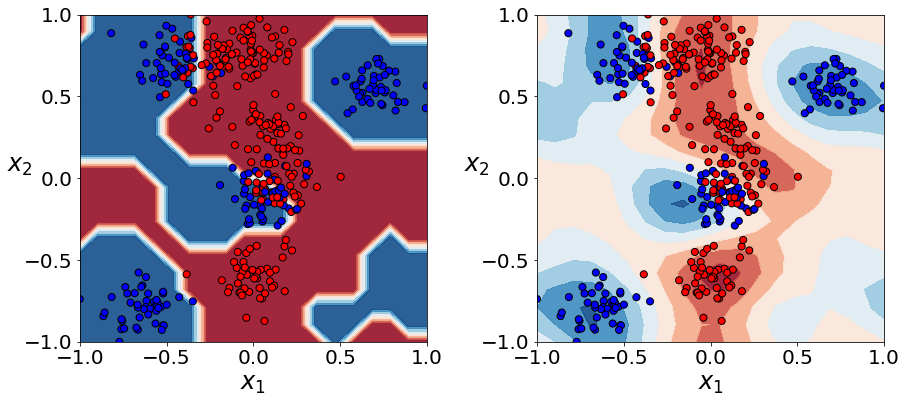

In [160]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
plot_predictions(best_qsvc, ax1, axes, N=20)
plot_dataset(X, y, ax1, axes)
plot_decisions(best_qsvc, ax2, axes, N=20)
plot_dataset(X, y, ax2, axes)
plt.tight_layout()
plt.show()

# Test 3

Best grid search parameters: {'C': 1, 'alpha': 2.5, 'feature_map': ['h', 'rz', 'cy'], 'n_layers': 4, 'n_qubits': 4}
Best training score: 0.859116756396542

Train scores:
   Balanced accuracy:  0.92
                  F1:  0.92
             ROC_AUC:  0.99
                 MCC:  0.85

Test scores:
   Balanced accuracy:  0.91
                  F1:  0.90
             ROC_AUC:  0.90
                 MCC:  0.82


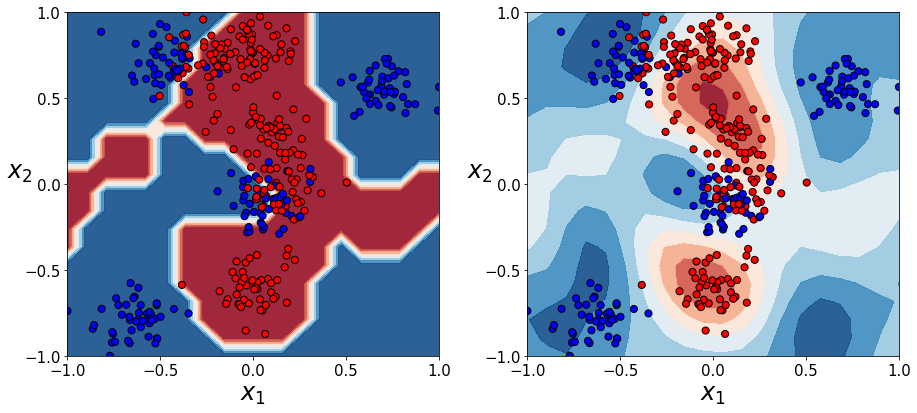

In [181]:
np.random.seed(seed=seed)

param_grid = {
    "alpha": [1.0, 1.5, 2.0, 2.5, 3.0, 3.5],
    "C": [1, 10],
    "n_layers": [1, 2, 3, 4, 5],
    "n_qubits": [2, 3, 4, 5],
    "feature_map": [
                    ['h', 'rz'], 
                    ['h', 'rz', 'cz'], 
                    ['h', 'rz', 'cx'], 
                    ['h', 'rz', 'cy'], 
                    ['rx', 'cx'], 
                    ['rx', 'cy'], 
                    ['rx', 'cz'], 
                    ['rx', 'ch'], 
                    ['rx', 'dcx'], 
                    ['rx', 'csx'], 
                    ['rx', 'swap'], 
                    ['rx', 'iswap'],
                    ['rx', 'rxx'],
                    ['rx', 'ryy'],
                    ['rx', 'rzz'],
                    ['rx', 'rzx'],
                   ],
}

gs = GridSearchCV(
    estimator=QKSVC(entanglement='linear', random_state=seed),
    param_grid=param_grid,
    scoring='matthews_corrcoef',
    n_jobs=1,
    refit=True,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=seed),
)
gs.fit(X_train, y_train)

print('Best grid search parameters:', gs.best_params_)
print('Best training score:', gs.best_score_)

train_scores = get_scores(gs.best_estimator_, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(gs.best_estimator_, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
plot_predictions(gs.best_estimator_, ax1, axes, N=20)
plot_dataset(X, y, ax1, axes)
plot_decisions(gs.best_estimator_, ax2, axes, N=20)
plot_dataset(X, y, ax2, axes)
plt.tight_layout()
plt.show()

1034
2250
0.853143642595172
params {'C': 10, 'alpha': 1.5, 'feature_map': ['h', 'rz'], 'n_layers': 3, 'n_qubits': 4}

Train scores:
   Balanced accuracy:  0.92
                  F1:  0.92
             ROC_AUC:  0.99
                 MCC:  0.85

Test scores:
   Balanced accuracy:  0.86
                  F1:  0.85
             ROC_AUC:  0.94
                 MCC:  0.74


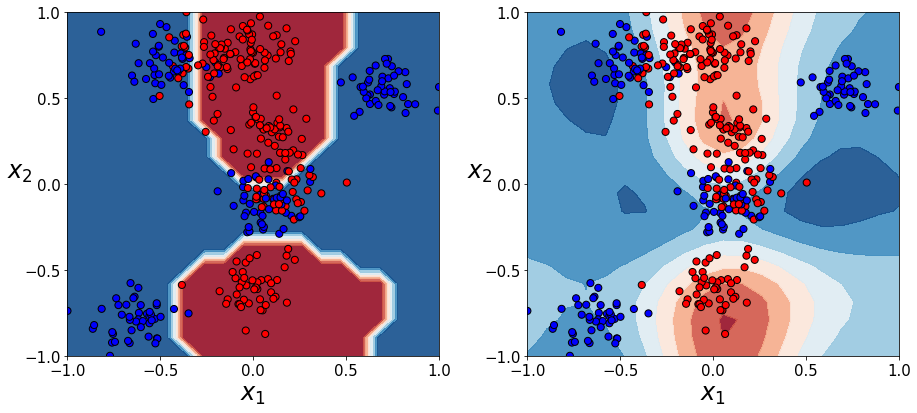

In [208]:
print(gs.best_index_)

i = -11
idx = np.argsort(gs.cv_results_['mean_test_score'])
print(idx[i])
print(gs.cv_results_['mean_test_score'][idx[i]])
print('params', gs.cv_results_['params'][idx[i]])

model(gs.cv_results_['params'][idx[i]])

In [245]:
v = gs.cv_results_['mean_test_score']
s = gs.cv_results_['std_test_score']

idxs = np.where((v > 0.85314) & (s < 0.12))[0]
print(idxs)

for i in idxs:
    print(i, v[i])
    print(gs.cv_results_['params'][i])

[2989 3305 3625]
2989 0.8540819657211
{'C': 10, 'alpha': 2.5, 'feature_map': ['rx', 'cy'], 'n_layers': 3, 'n_qubits': 3}
3305 0.8540819657211
{'C': 10, 'alpha': 3.0, 'feature_map': ['rx', 'cy'], 'n_layers': 2, 'n_qubits': 3}
3625 0.8540819657211
{'C': 10, 'alpha': 3.5, 'feature_map': ['rx', 'cy'], 'n_layers': 2, 'n_qubits': 3}


1034
{'C': 10, 'alpha': 2.5, 'feature_map': ['rx', 'cy'], 'n_layers': 3, 'n_qubits': 3}

Train scores:
   Balanced accuracy:  0.93
                  F1:  0.93
             ROC_AUC:  0.99
                 MCC:  0.85

Test scores:
   Balanced accuracy:  0.86
                  F1:  0.85
             ROC_AUC:  0.97
                 MCC:  0.74


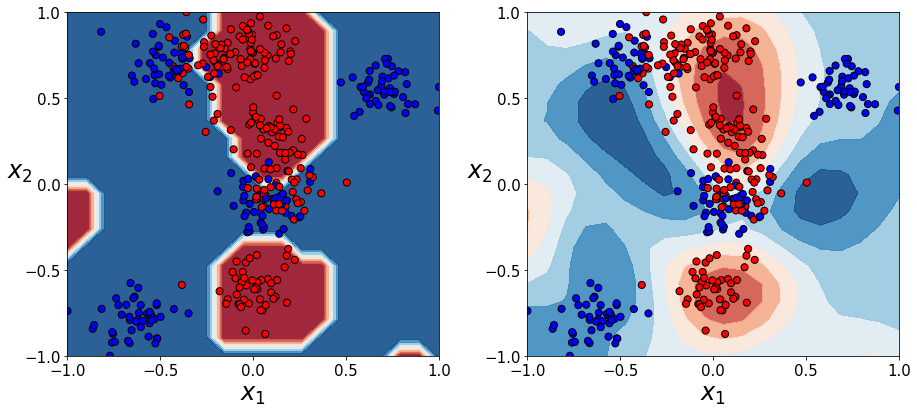

In [252]:
print(gs.best_index_)

i = 2989
params = gs.cv_results_['params'][i]
print(params)
model(params)

## Model cross-validation

In [253]:
np.random.seed(seed)

scoring = 0 # 0=acc, 1=f1, 2=roc
best_score = 0.0
scores_tr = []
scores_tt = []

train_size = 40
test_size = 20
n_splits = 5

for _seed in np.random.randint(2**16-1, size=5):
    # print('rnd seed', _seed)

    cv = StratifiedShuffleSplit(
        n_splits=n_splits, 
        train_size=train_size, test_size=test_size, 
        random_state=_seed
    )

    i = 0
    for train, test in cv.split(X, y):
        i += 1
        # print(f"Train/Test CV Subset {i}")

        # params = {'C': 10, 'alpha': 3.5, 'feature_map': ['rx', 'cy'], 'n_layers': 2, 'n_qubits': 3}
        
        qsvc = QKSVC(
            n_qubits=params['n_qubits'],
            n_layers=params['n_layers'],
            feature_map=params['feature_map'], entanglement='linear',
            alpha=params['alpha'], C=params['C'], 
            random_state=_seed
        ) 
        qsvc.fit(X[train,:], y[train])

        train_scores = get_scores(qsvc, X[train,:], y[train])
        test_scores = get_scores(qsvc, X[test,:], y[test])
        scores_tr.append(train_scores)
        scores_tt.append(test_scores)
        if test_scores[scoring] > best_score:
            best_score = test_scores[scoring]
            best_qsvc = qsvc

print('')
print('==== Cross-Validation Scores ====')
print("\nBest train score: ", best_score)
print_cv_scores(scores_tr, title='Train set:')
print_cv_scores(scores_tt, title='Test set:')


==== Cross-Validation Scores ====

Best train score:  0.9444444444444444

Train set:
   Balanced accuracy:  0.92 +- 0.03
                  F1:  0.92 +- 0.03
             ROC_AUC:  0.97 +- 0.02
                 MCC:  0.85 +- 0.06

Test set:
   Balanced accuracy:  0.82 +- 0.08
                  F1:  0.82 +- 0.08
             ROC_AUC:  0.90 +- 0.07
                 MCC:  0.65 +- 0.16


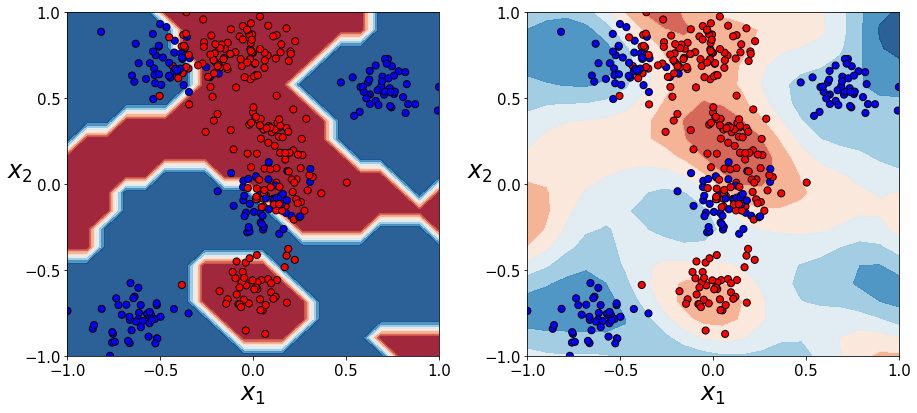

In [254]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
plot_predictions(best_qsvc, ax1, axes, N=20)
plot_dataset(X, y, ax1, axes)
plot_decisions(best_qsvc, ax2, axes, N=20)
plot_dataset(X, y, ax2, axes)
plt.tight_layout()
plt.show()

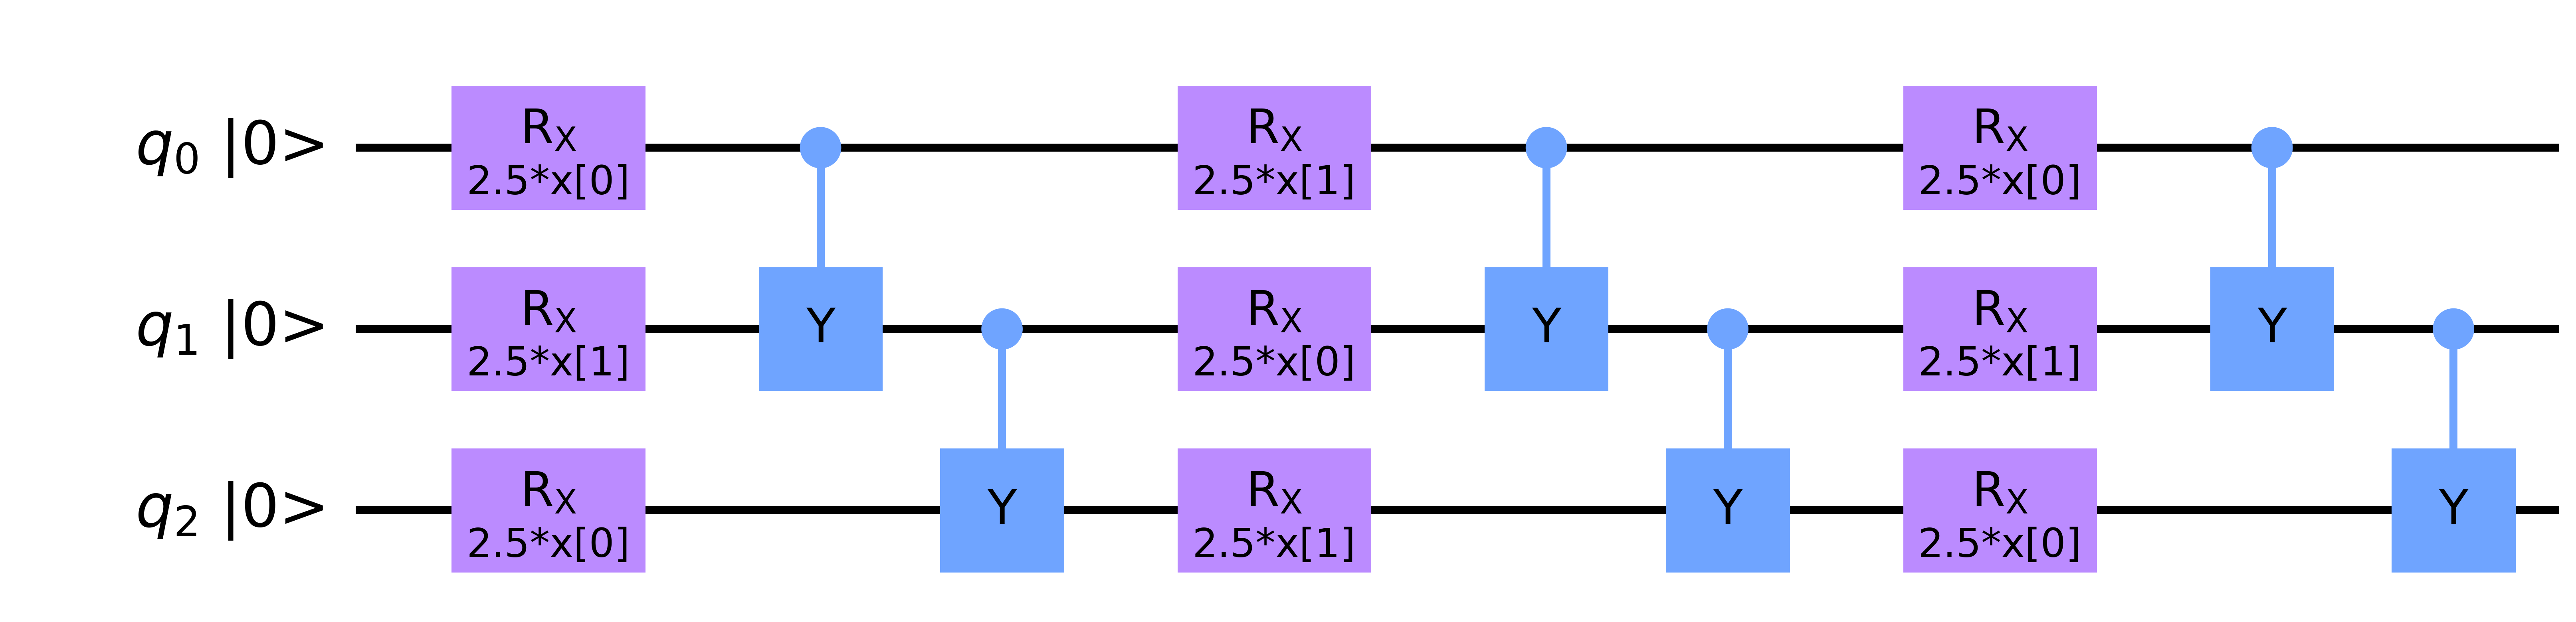

In [255]:
from qksvm.QuantumFeatureMap import QuantumFeatureMap

## Specify Feature Map
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=3,
    num_layers=3,
    gates=['RX', 'CY',], entanglement='linear',
    alpha=2.5
)

large_font = {
    "fontsize": 12,
    "subfontsize": 10,  
}
fm.draw(plot_barriers=False, fold=180, output='mpl', scale=10, style=large_font, initial_state=True)